In [1]:
# Python 3.7
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
import io
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

tickers = ['%5EGSPC','000001.SS']

data = None
while data is None:
    try:
        data = getdata(tickers,'946610000','1541808000','1d')
    except:
         pass

data['%5EGSPC'].tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-05,2726.370117,2744.270020,2717.939941,2738.310059,2738.310059,3623320000
2018-11-06,2738.399902,2756.820068,2737.080078,2755.449951,2755.449951,3510860000
2018-11-07,2774.129883,2815.149902,2774.129883,2813.889893,2813.889893,3914750000
2018-11-08,2806.379883,2814.750000,2794.989990,2806.830078,2806.830078,3630490000
2018-11-09,2794.100098,2794.100098,2764.239990,2781.010010,2781.010010,2507593534


In [2]:
ReturnSP = data['%5EGSPC']['Adj Close']/data['%5EGSPC']['Adj Close'].shift(1)-1
BuyHoldSP = data['%5EGSPC']['Adj Close']/float(data['%5EGSPC']['Adj Close'][:1])-1
BuyHold1ySP = data['%5EGSPC']['Adj Close']/data['%5EGSPC']['Adj Close'].shift(252)-1
BuyHoldSPytd = data['%5EGSPC']['Adj Close'][-252:]/float(data['%5EGSPC']['Adj Close'][-252])-1

ReturnSSE = data['000001.SS']['Adj Close']/data['000001.SS']['Adj Close'].shift(1)-1
BuyHoldSSE = data['000001.SS']['Adj Close']/float(data['000001.SS']['Adj Close'][:1])-1
BuyHold1ySSE = data['000001.SS']['Adj Close']/data['000001.SS']['Adj Close'].shift(252)-1
BuyHoldSSEytd = data['000001.SS']['Adj Close'][-252:]/float(data['000001.SS']['Adj Close'][-252])-1

BuyHoldAll = (BuyHoldSP*(0.8)+BuyHoldSSE*(0.2)).fillna(method='ffill')
BuyHold1yAll = (BuyHold1ySP*(0.8)+BuyHold1ySSE*(0.2)).fillna(method='ffill')
BuyHoldAllytd = (BuyHoldSPytd*(0.8)+BuyHoldSSEytd*(0.2)).fillna(method='ffill')

In [3]:
holdings = pd.DataFrame({'Asset 1':ReturnSP*0.8,'Asset 2':ReturnSSE*0.2}).fillna(0)
signal = pd.DataFrame({'Asset 1':BuyHold1ySP.shift(1),'Asset 2':BuyHold1ySSE.shift(1)}).fillna(method='ffill')

holdings['Asset 1'][signal['Asset 1'] > -0.17] = ReturnSP*1
holdings['Asset 2'][signal['Asset 1'] > -0.17] = ReturnSSE*0

holdings['Asset 1'][signal['Asset 2'] > 0.29] = ReturnSP*0
holdings['Asset 2'][signal['Asset 2'] > 0.29] = ReturnSSE*1

DynAssAll = (holdings['Asset 1']+holdings['Asset 2']).fillna(0).cumsum()
DynAssAll1y = (holdings['Asset 1']+holdings['Asset 2']).fillna(0).rolling(window=252).sum()
DynAssAllytd = (holdings['Asset 1'][-252:]+holdings['Asset 2'][-252:]).fillna(0).cumsum()

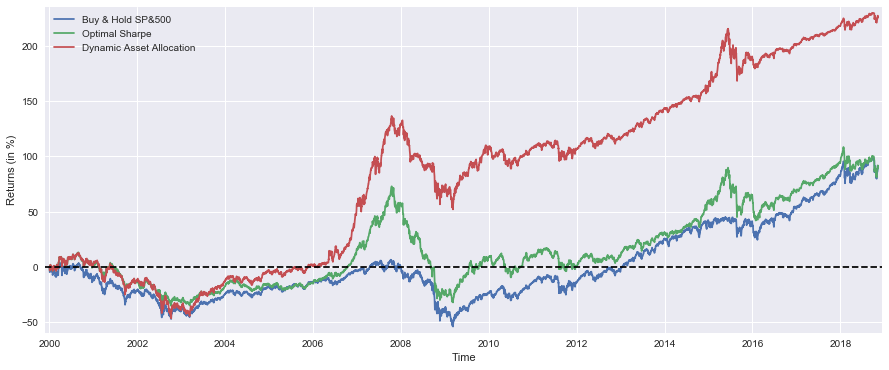

Median yearly excess return over SP500 = 1.8 %
"" "" "" "" over Optimal Sharpe = 3.0 %


In [4]:
plt.figure(figsize=(15,6))
plt.plot(BuyHoldSP*100, label='Buy & Hold SP&500')
plt.plot(BuyHoldAll*100, label='Optimal Sharpe')
plt.plot(DynAssAll*100, label='Dynamic Asset Allocation')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('Median yearly excess return over SP500 =',round(float(DynAssAll1y.median()-BuyHold1ySP.median())*100,1),'%')
print('"" "" "" "" over Optimal Sharpe =',round(float(DynAssAll1y.median()-BuyHold1yAll.median())*100,1),'%')

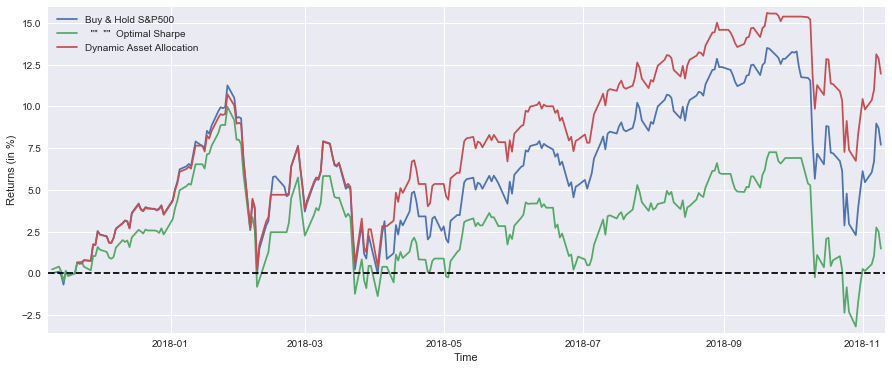

Buy & Hold S&P500 YTD Performance (at 09/11/2018) = 7.7 %
 "" "" Optimal Sharpe "" "" = 1.5 %
Strategy YTD Performance = 11.9 %


In [5]:
plt.figure(figsize=(15,6))
plt.plot(BuyHoldSPytd*100, label='Buy & Hold S&P500')
plt.plot(BuyHoldAllytd*100, label='  ""  ""  Optimal Sharpe')
plt.plot(DynAssAllytd*100, label='Dynamic Asset Allocation')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print('Buy & Hold S&P500 YTD Performance (at 09/11/2018) =',round(float(BuyHoldSPytd[-1:]*100),1),'%')
print(' "" "" Optimal Sharpe "" "" =',round(float(BuyHoldAllytd[-1:]*100),1),'%')
print('Strategy YTD Performance =',round(float(DynAssAllytd[-1:]*100),1),'%')